<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_wind_file_structure.ipynb" target="_blank"><< Exploring OSI SAF wind product structure</a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-wind/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_wind_introductory%2F1_3_OSI_SAF_mapping_wind.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF wind: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1a_OSI_SAF_wind_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_wind_FTP_data_access.ipynb</a>**

</div>
<hr>

# 2.1a Advanced Mapping example of an OSI SAF product

### Data used

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|
| HY-2B 25 km wind vectors | EO:EUM:DAT:0537 | <a href="https://osi-saf.eumetsat.int/products/osi-114-a" target="_blank">link</a> | OSI-114-a | 

### Learning outcomes

At the end of this notebook you will know;
* Map winds products using cartopy
* Advance mapping using cartopy (wind vector, colorbar and slection of data)

In this notebook we use an unique example in order to show some specifics mapping and can be apply with the other wind OSI SAF products

<div class="alert alert-info" role="alert">
    
## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Setting Parameters](#section1)
 1. [Mapping a wind dataset with cartopy](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [32]:
# library imports
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import numpy as np                 # a library that supports array manipulation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

##
<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_wind` create a plot figure of wind and wind vector of the wind osi saf product available in the directory **dir** with a specific output projection.
It is possible to chose the wind plot type : \
* quiver_no_colormap : plot colored wind quiver vector in function of wind speed
* barbs_no_colormap : plot colored wind barbs vector in function of wind speed
* quiver_colormap : plot black quiver for wind dir with a color map for wind speed
* barbs_colormap : plot black barbs for wind dir with a color map for wind speed

In [33]:
def mapping_wind(directory, output_projection, cmap, stride=1, type='quiver_no_colormap', title="", region=None): 
    """
    Function to map Wind osi saf products. 

    Args:
        dir (string)        : the directory where files are
        output_projection   : the output projection to plot map
        cmap                : color palette
        stride (int)        : select data
        type (string)       : type of wind plot
        title (string)      : title of the plot
        region (list)       : the region to zoom in. If not region is given, plot a global map
        
    Returns:
        im                  : the plotting figure
    """
    
    # set data projection
    data_projection=ccrs.PlateCarree()

    # define plot carateristics
    ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
    ax.set_global()
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
    ax.coastlines()    # Add coastline
    # Select region to zooming 
    if region : 
        ax.set_extent(region, crs=output_projection)
        scale = 500
    else :
        ax.set_global()
        scale = None

    # Add title
    plt.title(title, fontsize=18)
    
    # open and plot osi saf netcdf wind files
    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
            lat = nc.variables['lat'][:]    
            lon = nc.variables['lon'][:]
            wind_speed = nc.variables['wind_speed'][:]
            wind_dir = nc.variables['wind_dir'][:]
            wvc_quality_flag  = nc.variables['wvc_quality_flag'][:]
            nc.close()

            # plotting wind barbs in cartopy requires u and v and components.
            u = np.full_like(lat,0)
            v = np.full_like(lat,0)
            lat = np.where(np.isnan(lat), 0, lat)
            lon = np.where(np.isnan(lon), 0, lon)
            wind_speed = np.ma.masked_where(lon<1, wind_speed)
            
            u[:,:] = wind_speed * np.cos(np.radians(90 - wind_dir[:,:]))
            v[:,:] = wind_speed * np.sin(np.radians(90 - wind_dir[:,:]))

            
            # plotting wind Arrows with no wind speed colormap
            if type == 'quiver_no_colormap':
                im = ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], v[::stride,::stride], wind_speed[::stride,::stride], transform=data_projection, 
                    cmap=cmap, scale=scale)
            # plotting wind Arrows with wind speed colormap
            elif type == 'quiver_colormap':
                im = ax.contourf(lon,lat,wind_speed, np.arange(0,20,0.05), transform=data_projection, cmap=cmap)
                ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                                v[::stride,::stride], transform=data_projection, 
                                color = 'black', scale=scale)
            # plotting wind barbs with no wind speed colormap
            elif type == 'barbs_no_colormap':
                im = ax.barbs(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                            v[::stride,::stride], wind_speed[::stride,::stride], cmap=cmap, transform=data_projection)
            # plotting wind barbs with wind speed colormap
            elif type == 'barbs_colormap':
                im = ax.contourf(lon,lat,wind_speed, np.arange(0,20,0.05), transform=data_projection, cmap=cmap)
                ax.barbs(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                            v[::stride,::stride], transform=data_projection, 
                            color = 'black')
            else :
                print(f'{type} not recognize') 
                
            im.set_clim(0,25)
    return im

The function name `add_colorbar` create a colorbar of the image im.

In [34]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.1,0.1,0.75,0.02))
        ax = fig.add_axes([0.43,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.85,0.2,0.02,0.85))
        ax = fig.add_axes([0.8,.1,0.1,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('Wind Speed [m/s]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting Parameters
[Back to top](#TOC-TOP)

</div>

Select the direcory where the data of HY-2B 25 km wind is available

In [35]:
directory = os.path.join(os.path.dirname(os.getcwd()),'1_OSI_SAF_wind_introductory', 'products', 'hy_2b', '25')

Select geographical area for zooming map

In [36]:
# Set area
lon_min = 0
lon_max = 60
lat_min = -30
lat_max = -60

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>. 

In [37]:
cmap = mpl_cm.get_cmap('RdYlBu_r')

We also recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> .

In [38]:
# another choice could be
#cmap = cmocean.cm.speed

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Advanced mapping : Adding wind vector
[Back to top](#TOC-TOP)

</div>

It is possible to plot wind using vector to show wind direction.\
Wind direction and wind speed can be plot using different representation :
* monochrome Arrows (wind direction) and map color (wind speed)
* monochrome Barbs (wind direction) and map color (wind speed)
* colored arrows
* colored Barbs

### Monochrome Arrows
First, we will show you a wind plot example with monochrome arrows overlay with a color map for wind speed.\
In order to do that, we select the plot type **quiver_colormap** into the `mapping_wind()` function .

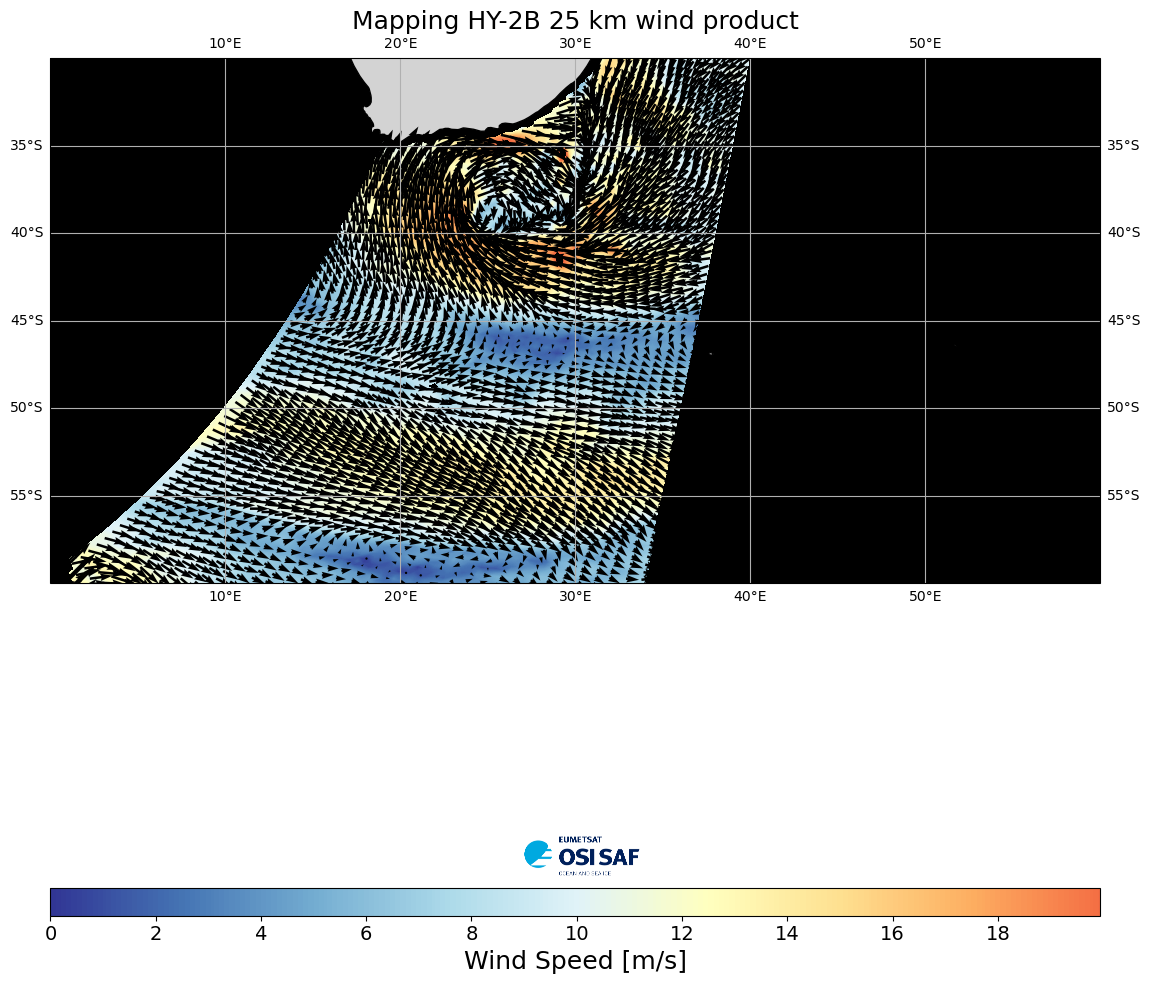

In [39]:
# create figure
fig = plt.figure(figsize=(14,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_colormap', 
                  stride = 2,
                  title="Mapping HY-2B 25 km wind product",
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Monochrome Barbs
We select the plot type **barbs_colormap** into the `mapping_wind()` function .

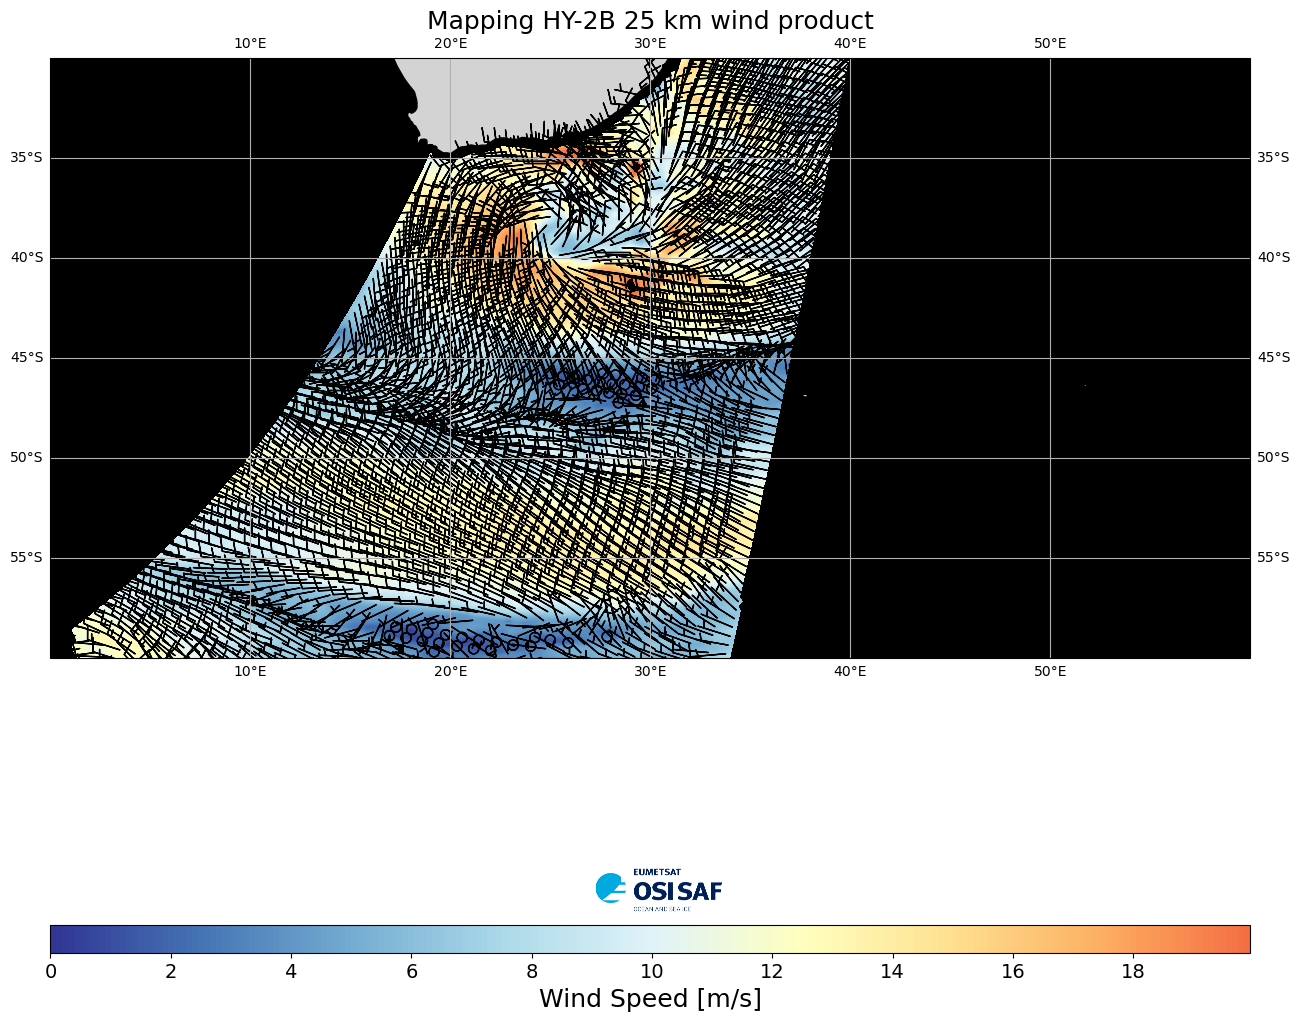

In [40]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='barbs_colormap', 
                  stride = 2,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Colored Arrows
Then, in order to plot wind speed and wind direction using only arrow we select the plot type **quiver_no_colormap**.

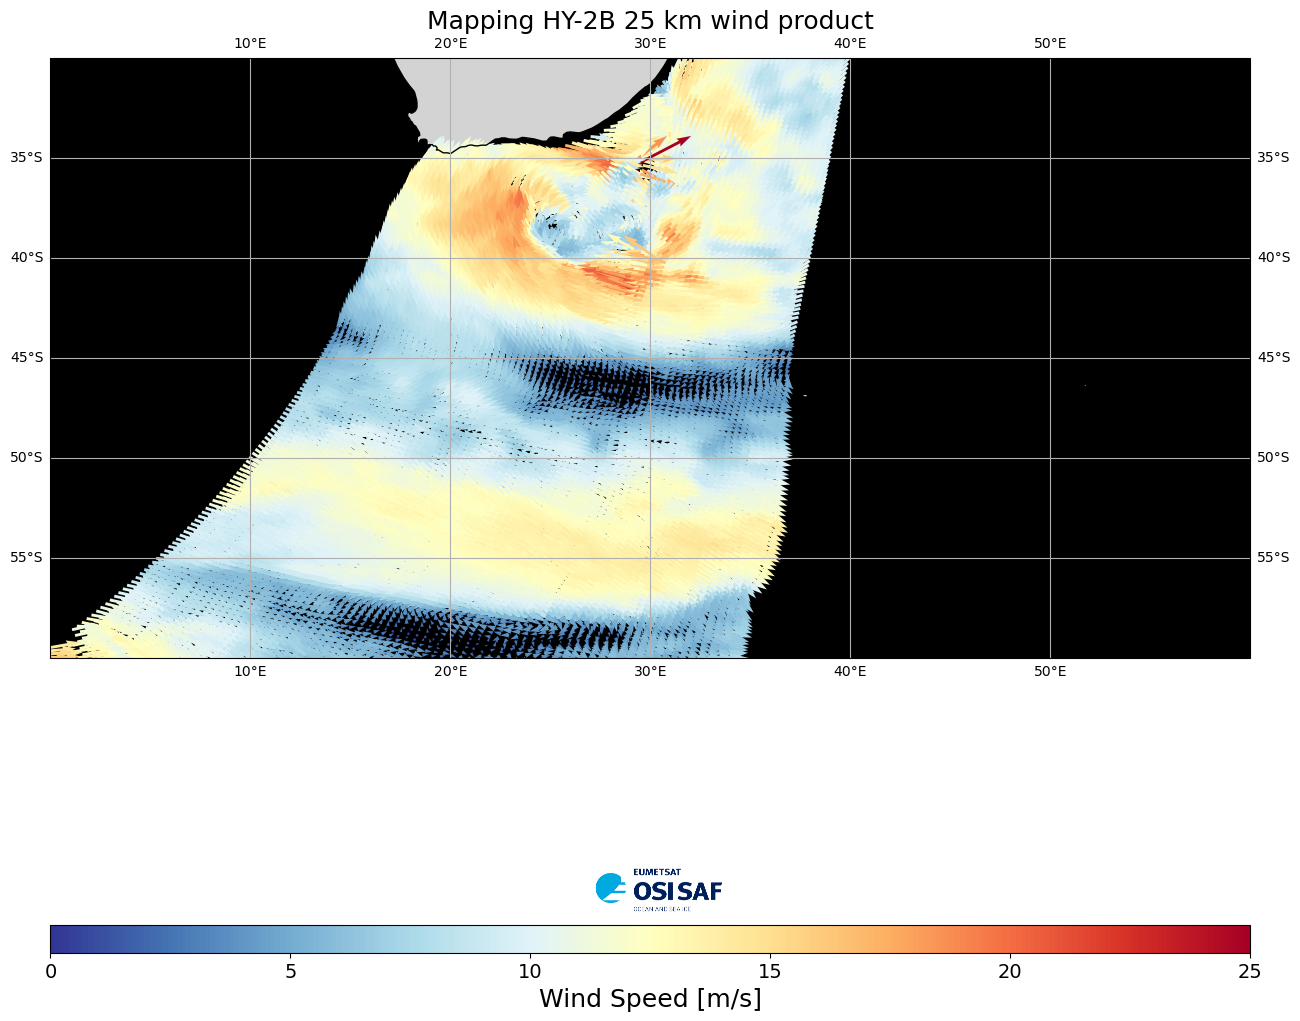

In [41]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  stride = 1,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Colored Barbs
Then, in order to plot wind speed and wind direction using only arrow we use alse the function `.barbs()` by adding the parameter **Wind speed**.

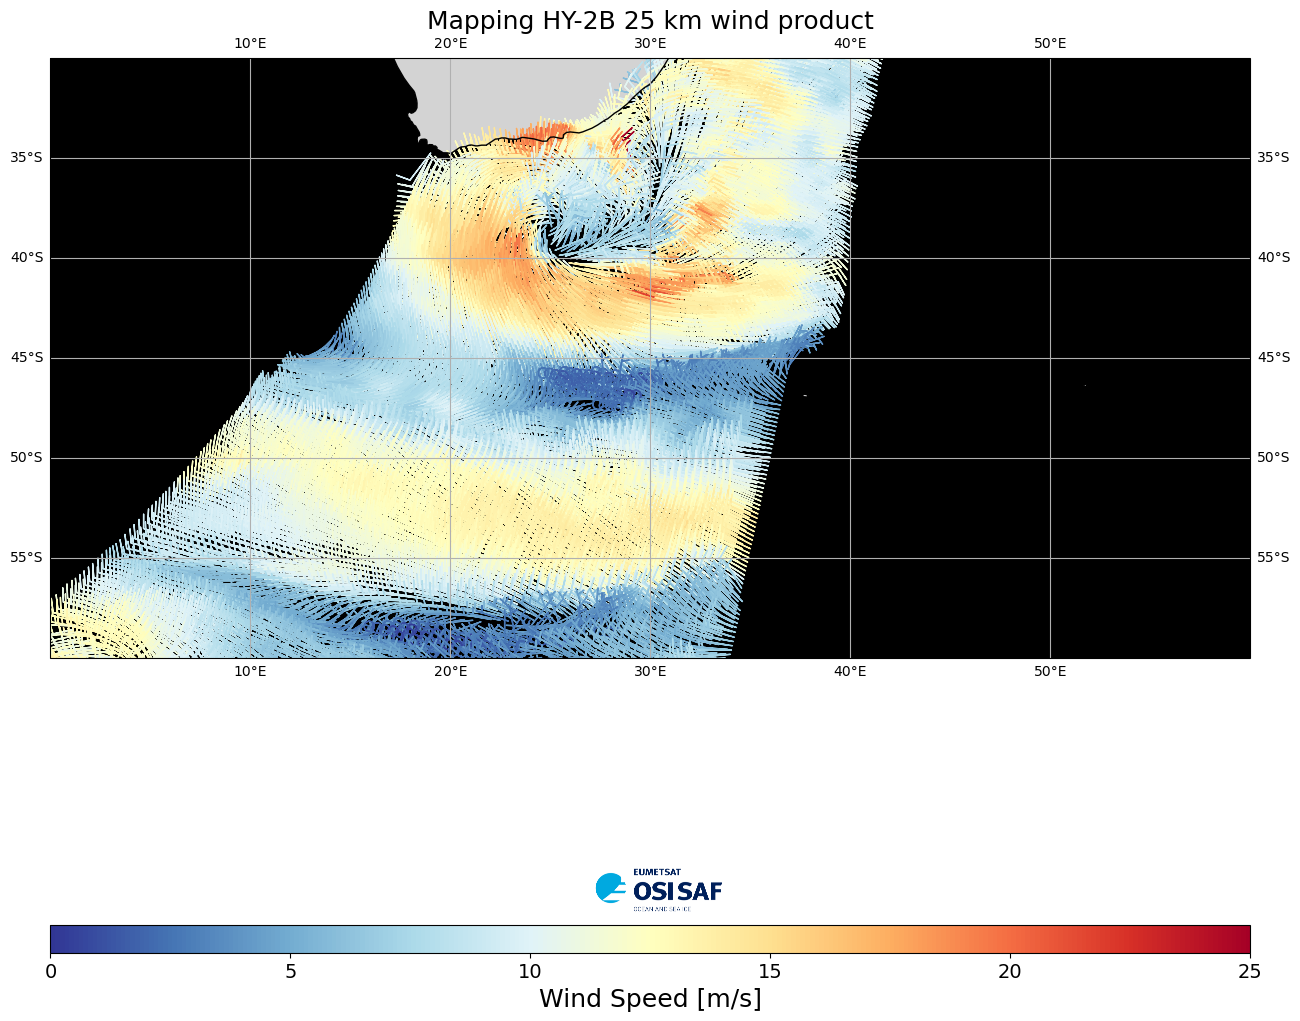

In [42]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection,
                  cmap, 
                  type='barbs_no_colormap', 
                  stride = 1,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Advanced mapping : Selecting data
[Back to top](#TOC-TOP)

</div>

It is possible to select some data to have a visible an clean plot .\
For example, the data longitude are selecting by using the command `lon[stride::stride]` mean that we select only one value out of **stride**.

When stride is equal to 2

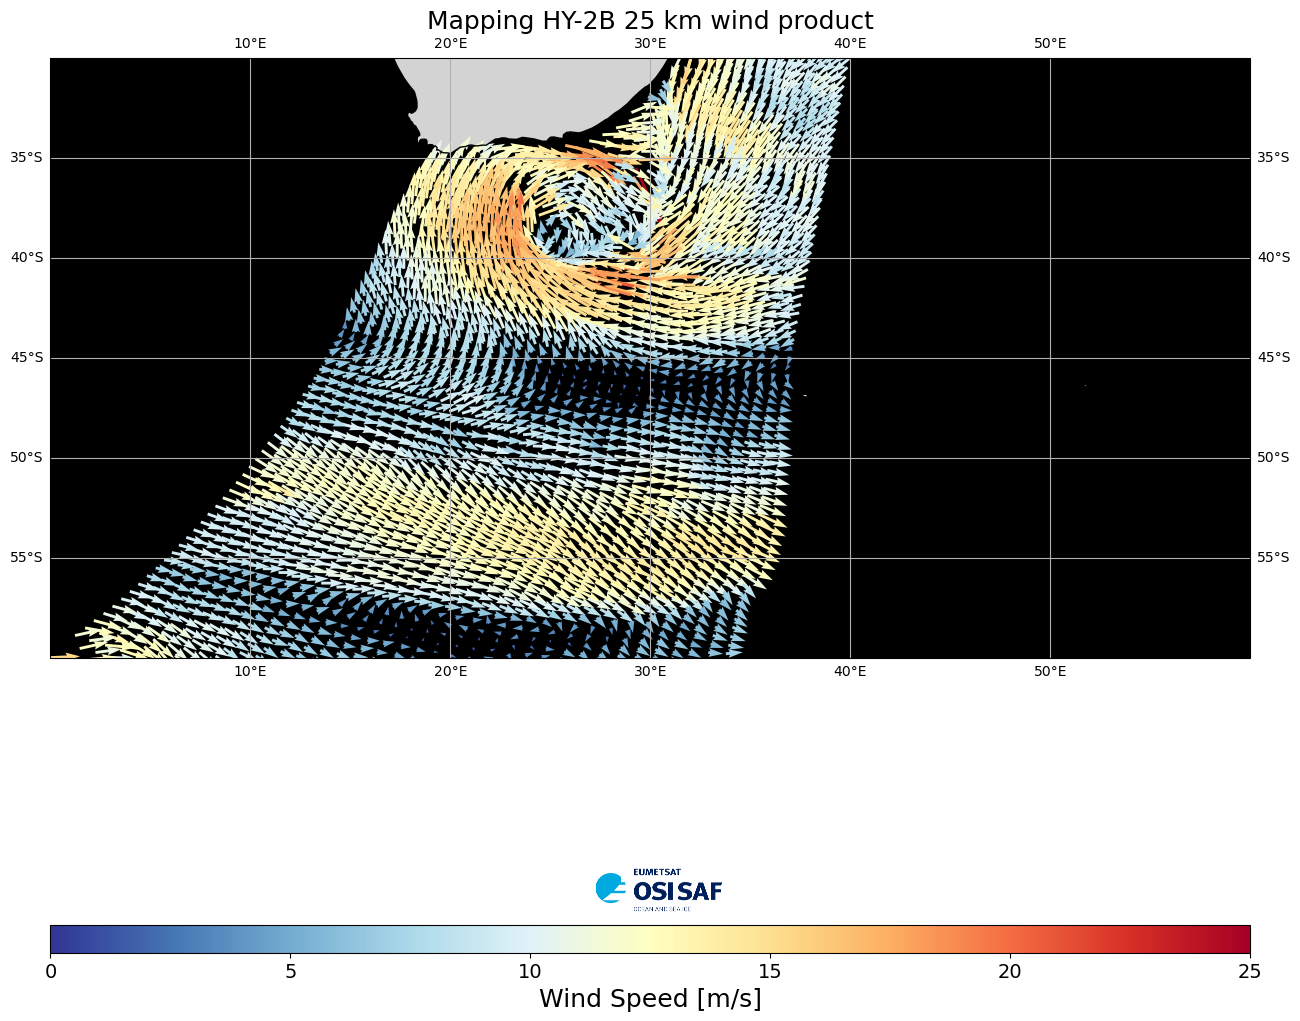

In [43]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  stride = 2,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

When stride is equal to 4

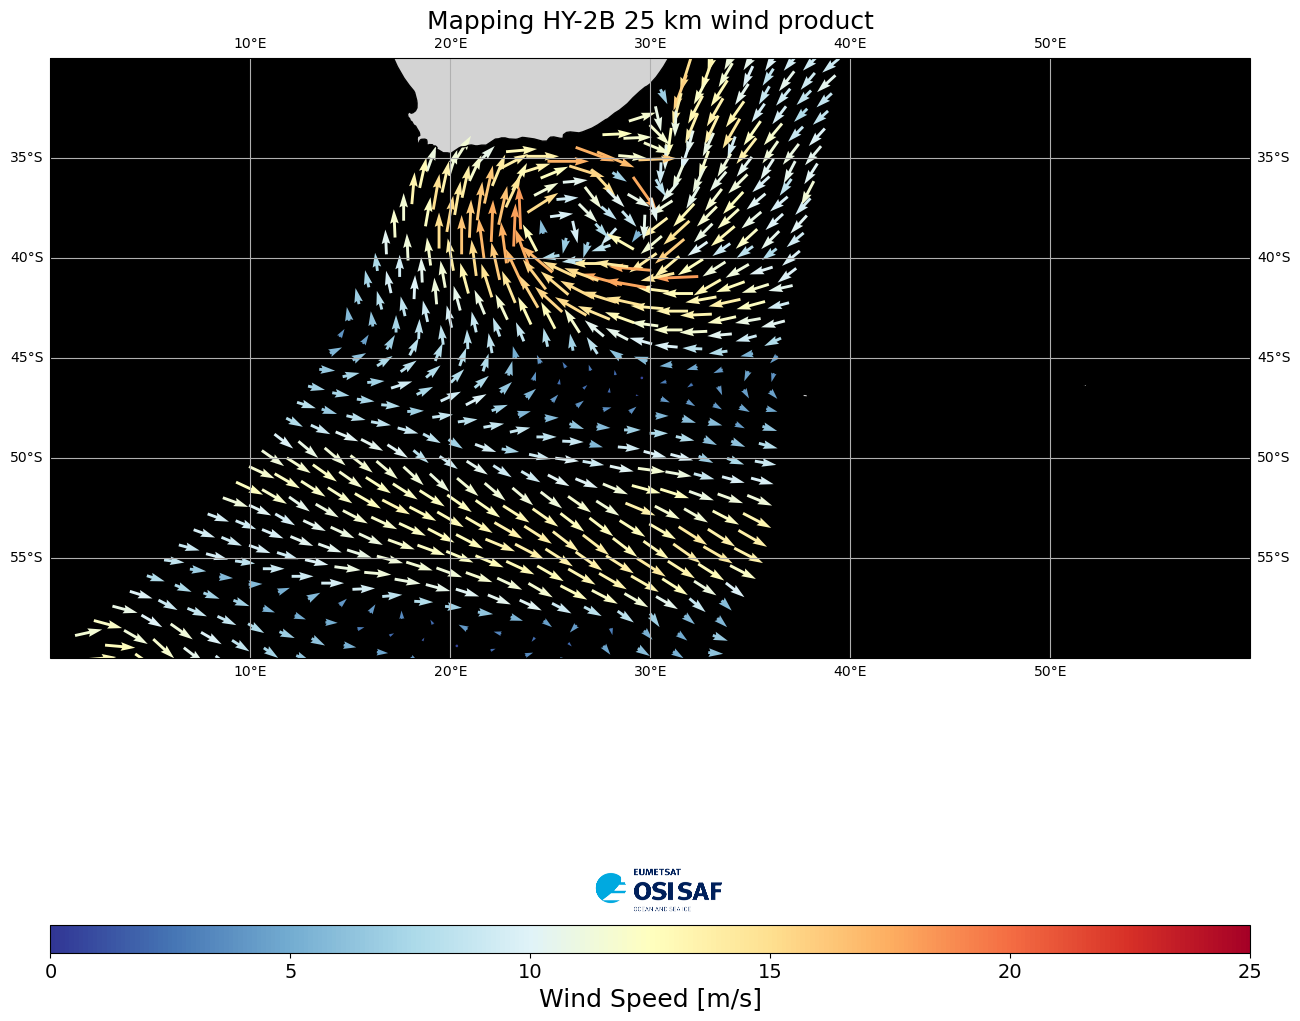

In [44]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  stride = 4,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Advanced mapping : colorbar
[Back to top](#TOC-TOP)

</div>

Colorbar can be change in different way : 
* Orientation 
* Dicrete or continuous 
* Ending 

### Orientation

In order to have an horizontal colorbar orientation, we change the value of the parameter `orientation` in the function `add_colorbar()` with `orientation='horizontal`.

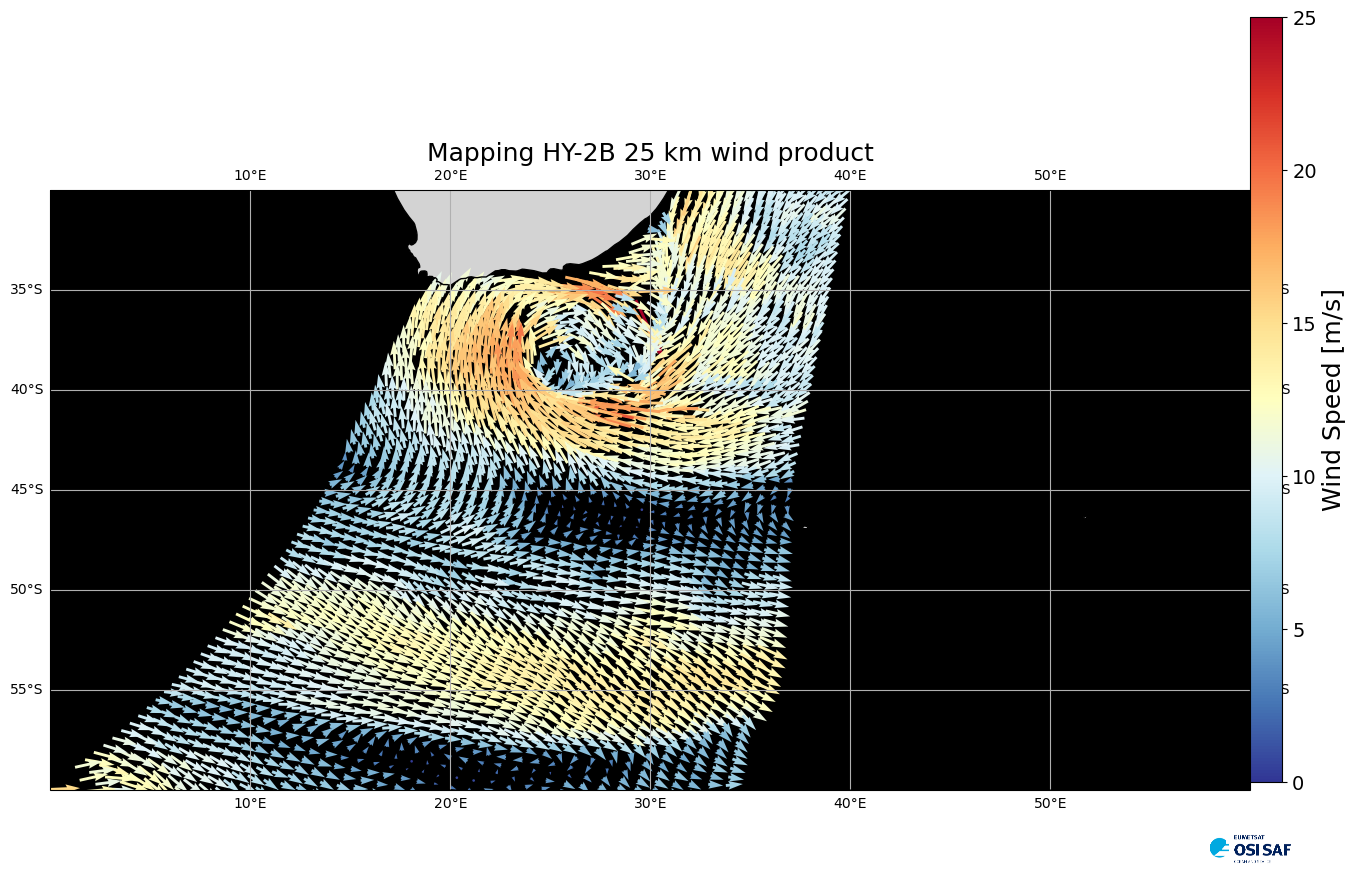

In [45]:
# Create figure
fig = plt.figure(figsize=(16,9))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection,
                  cmap,
                  type='quiver_no_colormap', 
                  stride = 2,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

### Dicrete Colorbar

#### Map with contourf function

By usinf `.contourf()` function the colorbar shape is manage by the function itself.\
We can change the number of color by changing the **levels** parameter.

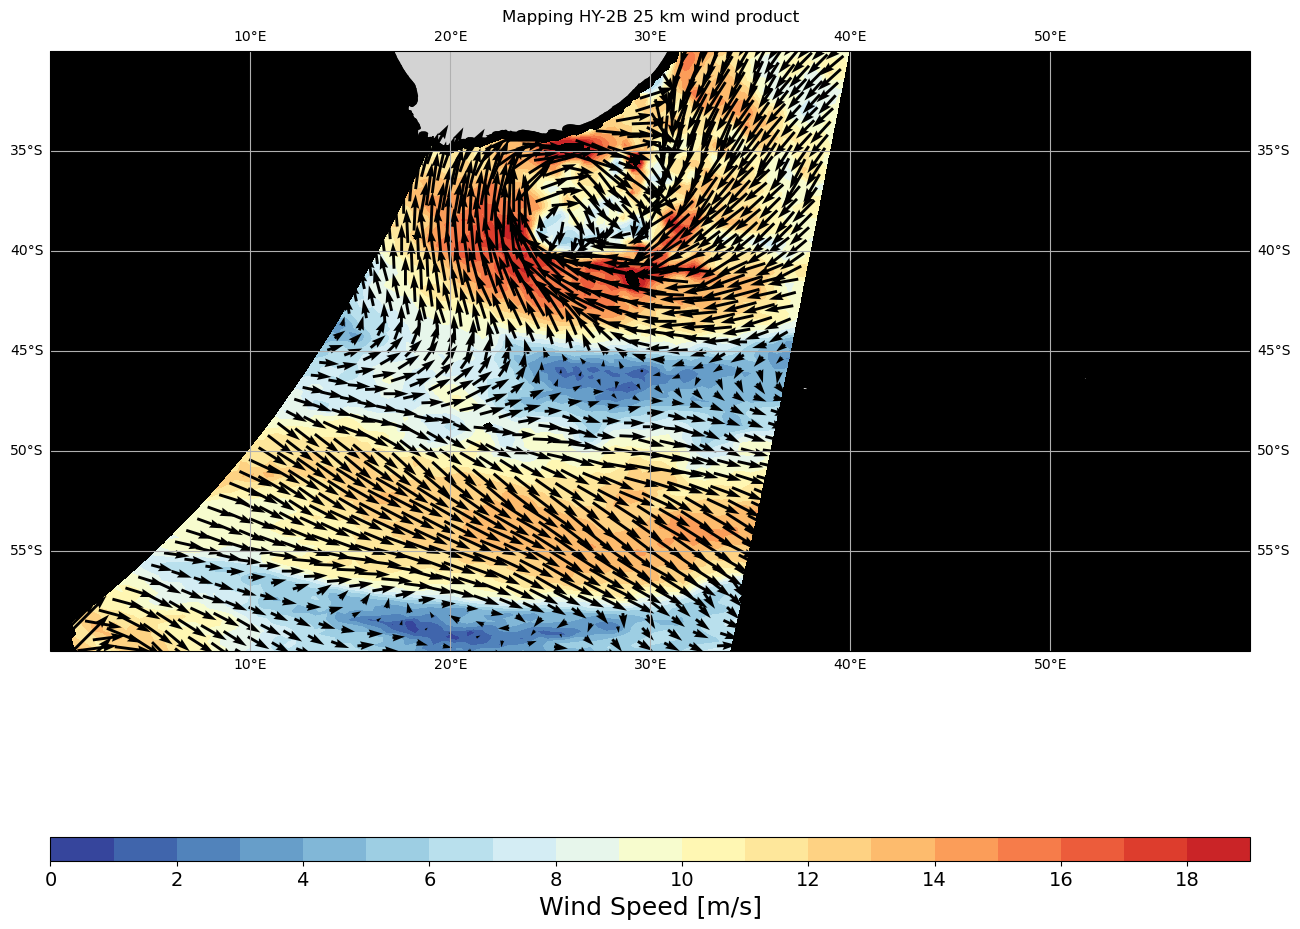

In [46]:
# For HY-2B 25 km wind
fig = plt.figure(figsize=(16,12))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2B 25 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset((directory + '/' + filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        wind_dir = nc.variables['wind_dir'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind barbs in cartopy requires u and v and components.
        u = np.full_like(lat,0)
        v = np.full_like(lat,0)
        u[:,:] = wind_speed * np.cos(np.radians(90 - wind_dir[:,:]))
        v[:,:] = wind_speed * np.sin(np.radians(90 - wind_dir[:,:]))
        stride = 3  #Select some data
        
        # Minimum and maximum wind speed
        max = np.ma.max(wind_speed)
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, levels=np.arange(0,20,1), transform=data_projection, cmap=cmap)
        
        # plotting wind direction
        ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                v[::stride,::stride], transform=data_projection, 
                 color = 'black', scale = 400)
        
        im.set_clim(0,20)
        
# Adding a colorbar
axc = fig.add_axes((0.1,0.10,0.75,0.02))
cb = plt.colorbar(im, orientation='horizontal', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

#### Map Without contourf function

The appearance of colorbar can be change by adding the parameter *discrete=True" in `add_colorbar()` function

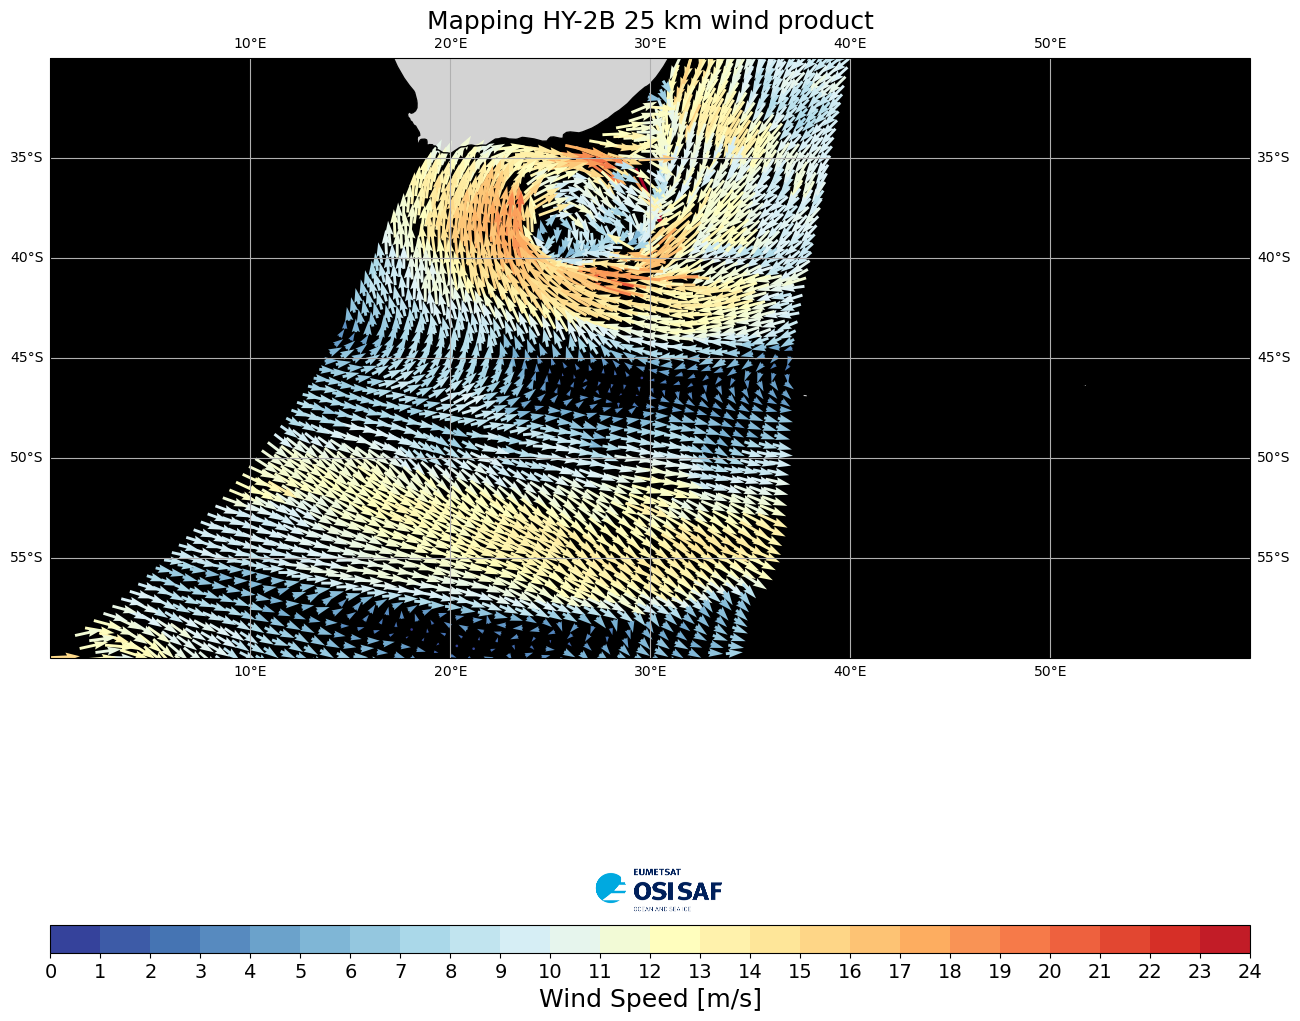

In [47]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  stride = 2,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', discrete=True, cmap=cmap)

### Ending

It is possible to add specific shape to the ending of the colorbar by adding the parameter **extend** into `add_colorbar()` function or `.contourf()` function.\
The **extent** parameter can take 3 differents value :
* 'both' : add ending to both extremity 
* 'min' : add ending to the minimum extremity
* 'max' : add ending to the maximum extremity

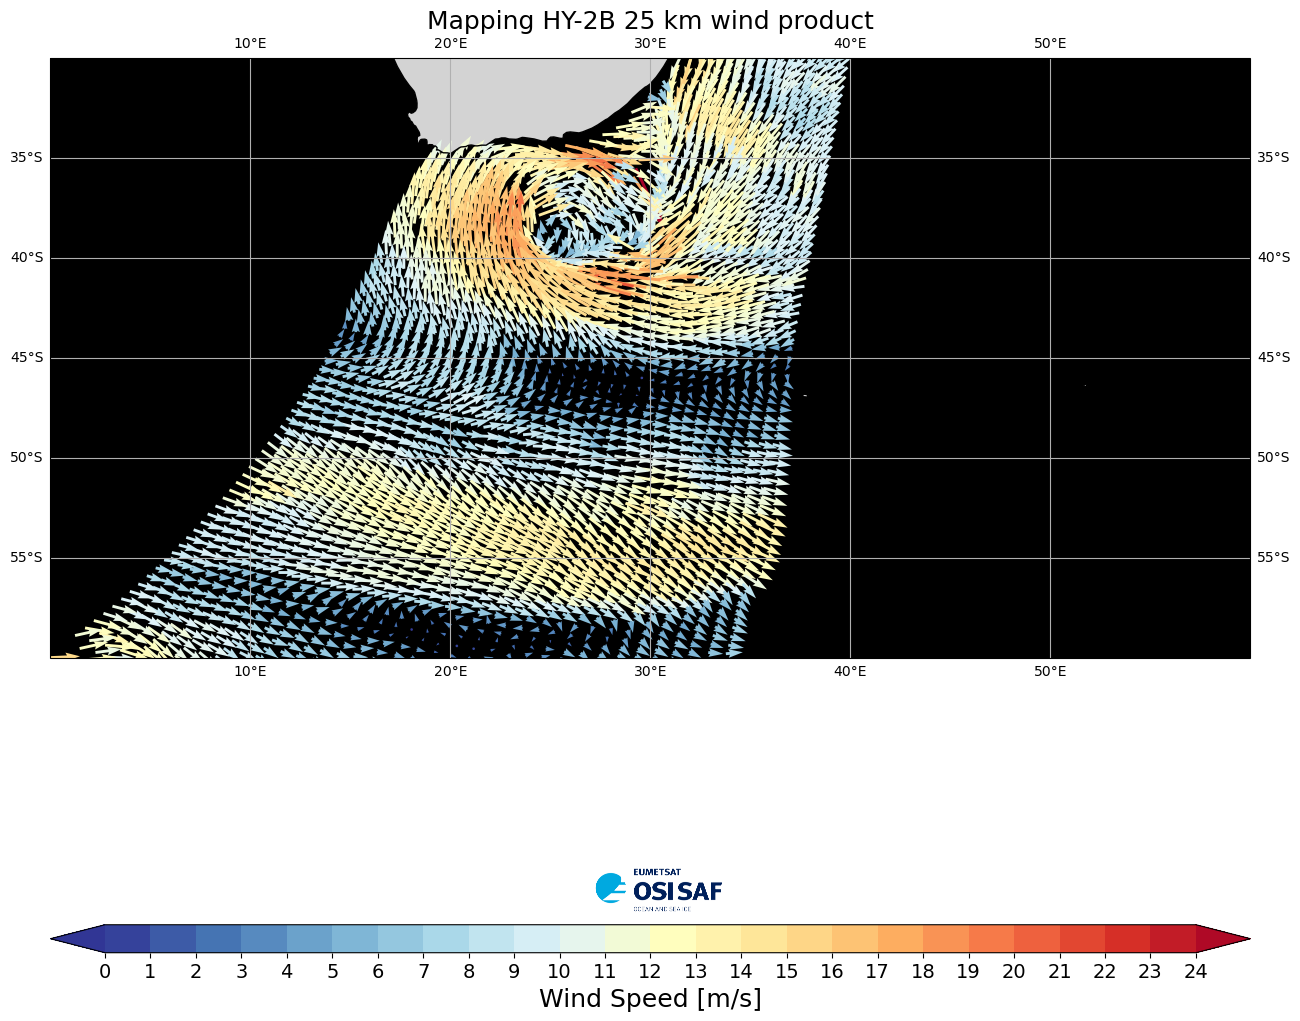

In [48]:
# Create figure
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection=ccrs.PlateCarree()

# Mapping wind
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  stride = 2,
                  title="Mapping HY-2B 25 km wind product", 
                  region=[lon_min,lon_max,lat_min,lat_max])

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap, discrete=True, extend='both')

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_wind_file_structure.ipynb" target="_blank"><< Exploring OSI SAF wind product structure</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>